In [1]:
import pandas as pd 
import os
import time
import csv
import itertools
import collections
import itertools
import matplotlib.pyplot as plt
import seaborn as sns

import copy as cp
import numpy as np 
from numpy.fft import fft, ifft
from typing import Tuple

import scipy
from scipy import stats
from sklearn import preprocessing, svm
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score, confusion_matrix
from sklearn.utils import resample
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn.neural_network import MLPClassifier

import tsfresh as tf
from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.feature_extraction import extract_features, MinimalFCParameters
from tsfresh.feature_extraction import ComprehensiveFCParameters

import keras
# import tensorflow as tsf
from keras.utils import plot_model
from keras.utils.np_utils import to_categorical
from keras.layers import Dense, Convolution1D, MaxPool1D, Flatten, Dropout, Input, BatchNormalization, Activation, Embedding, Add, LSTM, SimpleRNN
from keras.models import Model, Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint


plt.rcParams["figure.figsize"] = (30,6)
plt.rcParams['font.size'] = (20)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.color'] = 'b'
plt.rcParams['axes.grid'] = True 

In [ ]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.RdYlBu):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def evaluate_model(history,X_test,y_test,model):
    scores = model.evaluate((X_test),y_test, verbose=0)
    print("Accuracy: %.2f%%" % (scores[1]*100))
    
    print(history)
    fig1, ax_acc = plt.subplots()
    plt.plot(history.history['accuracy'], linewidth=8, c='black')
    plt.plot(history.history['val_accuracy'], linewidth=8, c='red')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Model - Accuracy')
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()
    
    fig2, ax_loss = plt.subplots()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Model- Loss')
    plt.legend(['Training', 'Validation'], loc='upper right')
    plt.plot(history.history['loss'], linewidth=8, c='black')
    plt.plot(history.history['val_loss'], linewidth=8, c='red')
    plt.show()
    target_names=['0','1','2','3','4']
    
    y_true=[]
    for element in y_test:
        y_true.append(np.argmax(element))
    prediction_proba=model.predict(X_test)
    prediction=np.argmax(prediction_proba,axis=1)
    cnf_matrix = confusion_matrix(y_true, prediction)

# Data Visualization & Preprocessing 

In [3]:
path = './mitbih_database/'
window_size = 180
maximum_counting = 10000

classes = ['N', 'L', 'R', 'A', 'V']
n_classes = len(classes)
count_classes = [0]*n_classes

X = list()
y = list()

# read files
filenames = next(os.walk(path))[2]

records = list()
annotations = list()
filenames.sort()

# segregating filenames and annotations
for f in filenames:
    filename, file_extension = os.path.splitext(f)
    
    # *.csv
    if(file_extension == '.csv'):
        records.append(path + filename + file_extension)

    # *.txt
    else:
        annotations.append(path + filename + file_extension)
        
# Records
for r in range(0,len(records)):
    signals = []

    with open(records[r], 'rt') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',', quotechar='|') # read CSV file\
        row_index = -1
        for row in spamreader:
            if(row_index >= 0):
                signals.insert(row_index, int(row[1]))
            row_index += 1
        
            # Read anotations: R position and Arrhythmia class
    example_beat_printed = False
    with open(annotations[r], 'r') as fileID:
        data = fileID.readlines() 
        beat = list()

        for d in range(1, len(data)): # 0 index is Chart Head
            splitted = data[d].split(' ') #The split() method splits a string into a list.
            splitted = filter(None, splitted)
            next(splitted) # Time... Clipping
            pos = int(next(splitted)) # Sample ID
            arrhythmia_type = next(splitted) # Type
            if(arrhythmia_type in classes):
                arrhythmia_index = classes.index(arrhythmia_type)
           # if count_classes[arrhythmia_index] > maximum_counting: # avoid overfitting
                #    pass
            #else:
                count_classes[arrhythmia_index] += 1
                if(window_size <= pos and pos < (len(signals) - window_size)):
                    beat = signals[pos-window_size:pos+window_size]     ## REPLACE WITH R-PEAK DETECTION
                    
                    X.append(beat)
                    y.append(arrhythmia_index)

# data shape
for i in range(0,len(X)):
        X[i] = np.append(X[i], y[i])
#         X[i].append(y[i])

X_df = pd.DataFrame(X)
#converting uV to mV

print('This is what the df looks like, where 0-359 is the time in ms and row # is the sample number')
X_df.head()

This is what the df looks like, where 0-359 is the time in ms and row # is the sample number


,0,1,2,3,4,5,6,7,8,9,...,351,352,353,354,355,356,357,358,359,360
0,957,956,961,964,964,966,965,966,967,969,...,957,958,958,955,955,955,960,958,957,0
1,950,951,952,951,956,959,961,960,958,958,...,948,950,952,951,952,951,948,950,951,0
2,946,949,952,956,957,958,957,957,959,960,...,957,957,958,957,956,957,960,956,956,0
3,960,961,960,959,961,965,967,964,965,967,...,956,958,960,961,959,957,953,955,956,0
4,939,940,943,948,950,951,951,951,955,958,...,962,962,962,958,957,958,960,959,959,0


Text(0, 0.5, 'Amplitude (mV)')

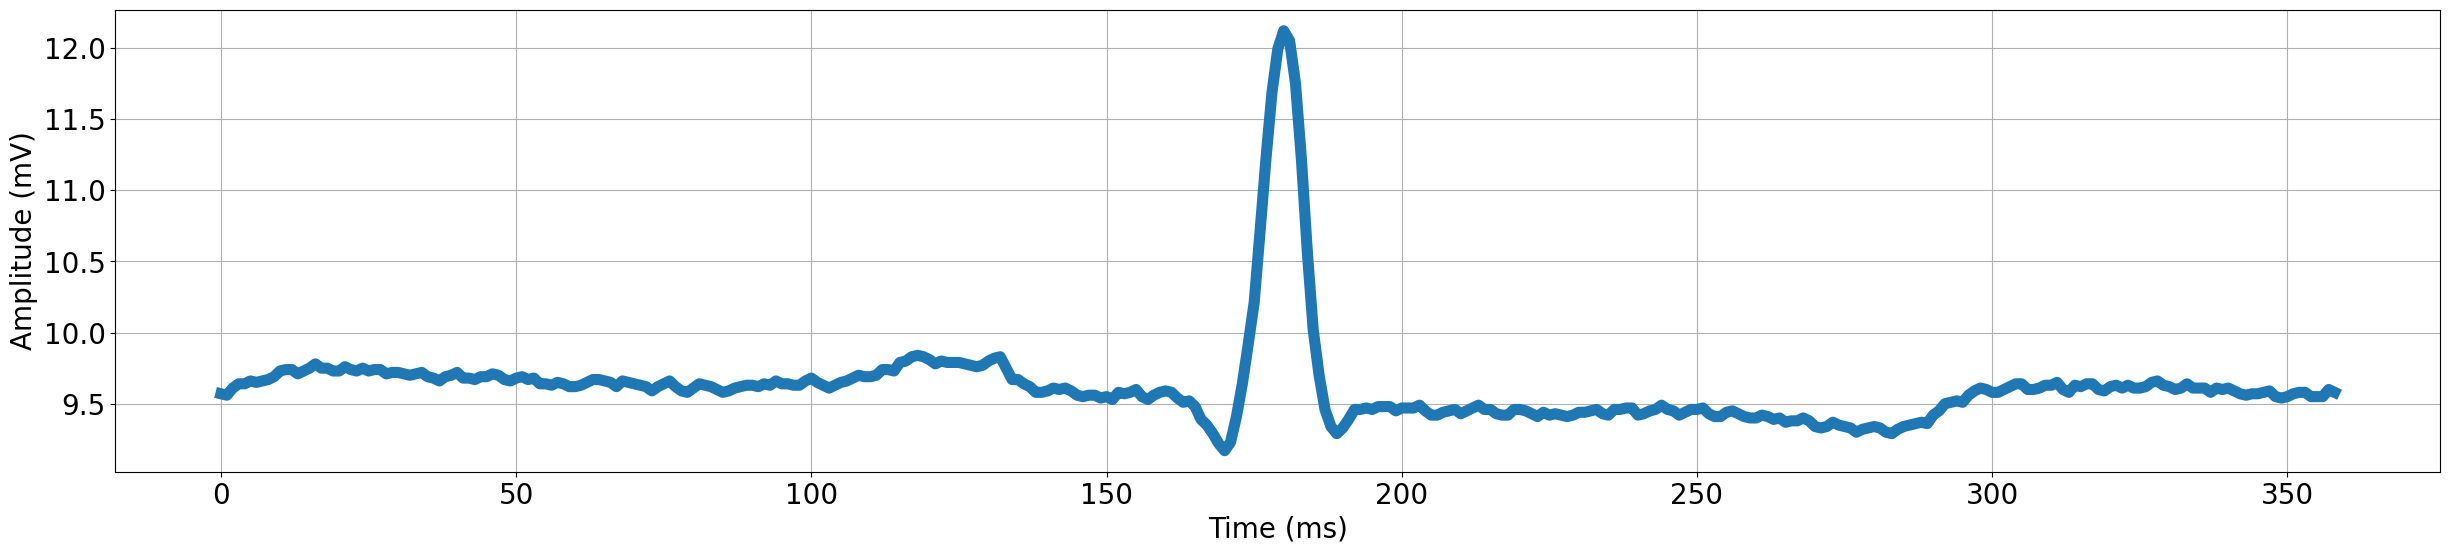

In [4]:
#print an example beat in mV
ex = X_df/100
ex.iloc[0,0:359].plot(linewidth=8)
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude (mV)')

0    75011
1     8071
2     7255
4     7129
3     2546
Name: 360, dtype: int64


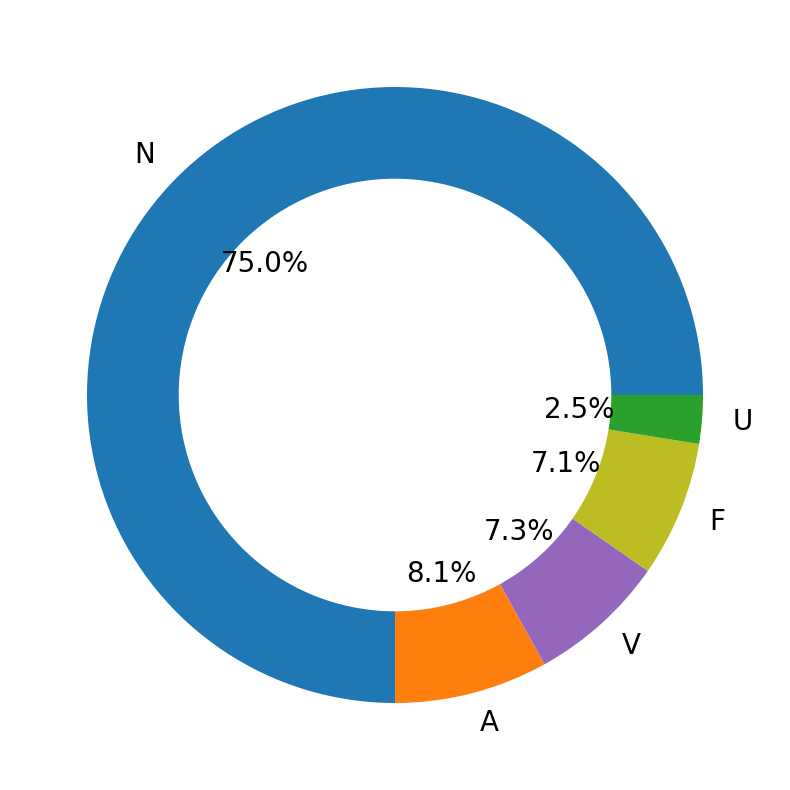

In [5]:
#data distribution before resampling
per_class = X_df[X_df.shape[1]-1].value_counts()
print(per_class)
plt.figure(figsize=(30,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(per_class, labels=['N', 'A', 'V', 'F', 'U'], colors=['tab:blue','tab:orange','tab:purple','tab:olive','tab:green'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

In [6]:
#resample the data so that there are equal amounts of each category
df_1=X_df[X_df[X_df.shape[1]-1]==1]
df_2=X_df[X_df[X_df.shape[1]-1]==2]
df_3=X_df[X_df[X_df.shape[1]-1]==3]
df_4=X_df[X_df[X_df.shape[1]-1]==4]
# df_5=X_train_df[X_train_df[X_train_df.shape[1]-1]==5]
df_0=(X_df[X_df[X_df.shape[1]-1]==0]).sample(n=6000,random_state=42)

df_1_upsample=resample(df_1,replace=True,n_samples=6000,random_state=122)
df_2_upsample=resample(df_2,replace=True,n_samples=6000,random_state=123)
df_3_upsample=resample(df_3,replace=True,n_samples=6000,random_state=124)
df_4_upsample=resample(df_4,replace=True,n_samples=6000,random_state=125)
# df_5_upsample=resample(df_5,replace=True,n_samples=5000,random_state=126)

# X_train_df=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample,df_5_upsample])
X_df_resam=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample])

0    6000
1    6000
2    6000
3    6000
4    6000
Name: 360, dtype: int64


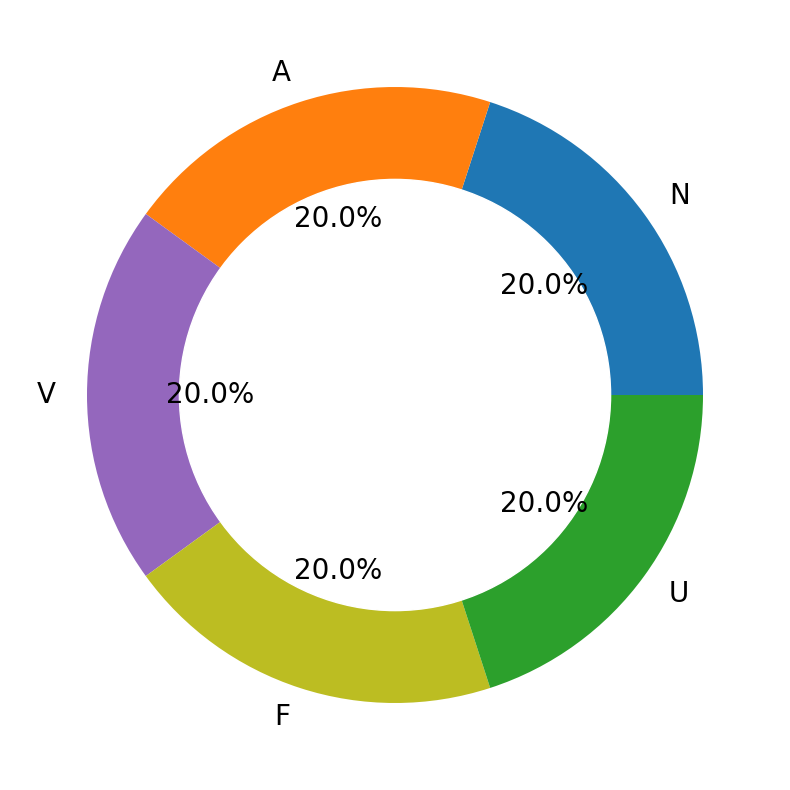

In [7]:
#show redistribution of data
per_class = X_df_resam[X_df_resam.shape[1]-1].value_counts()
print(per_class)
plt.figure(figsize=(20,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(per_class, labels=['N', 'A', 'V', 'F', 'U'], colors=['tab:blue','tab:orange','tab:purple','tab:olive','tab:green'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

In [8]:
category = X_df_resam[360]
X_df_resam.drop([360], axis=1, inplace=True)
#change units from uV to mV
X_df_resam = X_df_resam/100

(4.0, 15.0)

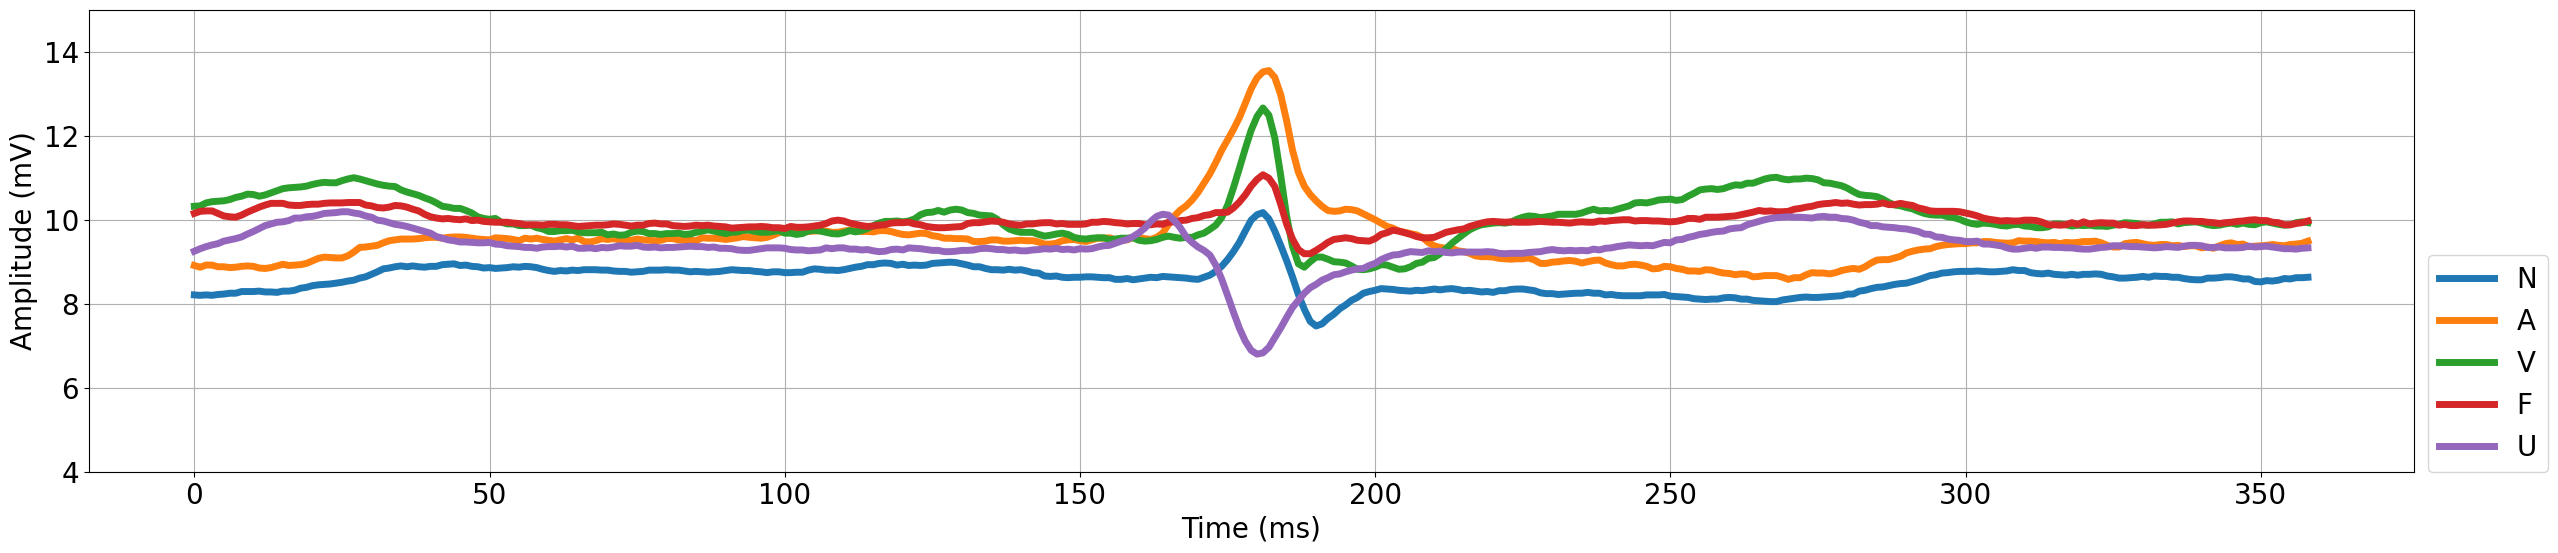

In [9]:
X_df_resam.iloc[450,0:359].plot(linewidth=5)
X_df_resam.iloc[7500,0:359].plot(linewidth=5)
X_df_resam.iloc[15000,0:359].plot(linewidth=5)
X_df_resam.iloc[21000,0:359].plot(linewidth=5)
X_df_resam.iloc[27000,0:359].plot(linewidth=5)
plt.legend(labels=['N', 'A', 'V', 'F', 'U'], bbox_to_anchor=[1, 0.5])
plt.ylabel('Amplitude (mV)')
plt.xlabel('Time (ms)')
plt.ylim(4,15)

In [81]:
#iterate over rows to calculate features by row

n_rows = np.arange(0,30000,1)
skewness = []
entropy =[]
variance = []
duplicate_max = []
abssum_changes = []
abs_energy = []
kurtosis = []
benford = []
minmax_dis_abs = []
minmax_dis = []
peak_location = []
peak_width = []
peak_time = []
upper = []
lower = []
mean_2deriv = []
rmse = []
start = time.time()
for r in n_rows:
    
    s = tf.feature_extraction.feature_calculators.skewness(X_df_resam.iloc[r,:])
    skewness.append(s)
    
    e = tf.feature_extraction.feature_calculators.sample_entropy(X_df_resam.iloc[r,:])
    entropy.append(e)
    
    v = tf.feature_extraction.feature_calculators.variance(X_df_resam.iloc[r,:])
    variance.append(v)
    
    d = tf.feature_extraction.feature_calculators.has_duplicate_max(X_df_resam.iloc[r,:])
    duplicate_max.append(d)
    
    c = tf.feature_extraction.feature_calculators.absolute_sum_of_changes(X_df_resam.iloc[r,:])
    abssum_changes.append(c)
    
    q = tf.feature_extraction.feature_calculators.abs_energy(X_df_resam.iloc[r,:])
    abs_energy.append(q) 
    
    k = tf.feature_extraction.feature_calculators.kurtosis(X_df_resam.iloc[r,:])
    kurtosis.append(k)
    
    b = tf.feature_extraction.feature_calculators.benford_correlation(X_df_resam.iloc[r,:])
    benford.append(b)
    
    msd = tf.feature_extraction.feature_calculators.mean_second_derivative_central(X_df_resam.iloc[r,:])
    mean_2deriv.append(msd)
    
    re = tf.feature_extraction.feature_calculators.root_mean_square(X_df_resam.iloc[r,:])
    rmse.append(re)
    
    m = X_df_resam.iloc[r,:]
    maxm = np.argmax(m)
    minm = np.argmin(m)
    dis_abs = abs(maxm-minm)
    minmax_dis_abs.append(dis_abs)
    
    m = X_df_resam.iloc[r,:]
    maxm = np.argmax(m)
    minm = np.argmin(m)
    dis = (maxm-minm)
    minmax_dis.append(dis)
    
    pl = (X_df_resam.iloc[r,:].sort_values(ascending=False).iloc[0])
    peak_location.append(pl)
    
    pw = (X_df_resam.iloc[r,:].sort_values(ascending=False).iloc[0]) - (X_df_resam.iloc[r,:].sort_values(ascending=False).iloc[1])
    peak_width.append(pw)
    
    pt = (X_df_resam.iloc[r,:].sort_values(ascending=False).index[0] - X_df_resam.iloc[r,:].sort_values(ascending=False).index[1])
    peak_time.append(pt)
    
    u = len(X_df_resam.iloc[r,:][X_df_resam.iloc[r,:] > ((X_df_resam.iloc[r,:].max() - X_df_resam.iloc[r,:].min())/2 + X_df_resam.iloc[r,:].min())])
    upper.append(u)
    
    l = len(X_df_resam.iloc[r,:][X_df_resam.iloc[r,:] < ((X_df_resam.iloc[r,:].max() - X_df_resam.iloc[r,:].min())/2 - X_df_resam.iloc[r,:].min())])
    lower.append(l)
    
    end = time.time()
    
    
    if (r % 10000 == 0) or (r == 0):
        print('On Row: ',r,'Time Elapsed: ',((end - start)/60),' min')

On Row:  0 Time Elapsed:  0.0005966862042744955  min
On Row:  10000 Time Elapsed:  4.209705301125845  min
On Row:  20000 Time Elapsed:  8.418750015894572  min


In [ ]:
#New Features: Discrete Fourier Transform & Continuous Wavelet Transform
#this cell runs slow because of the cwt, 

start = time.time()

fft_beat = abs((X_df_resam.apply(lambda x: fft(x), axis =1)))
fft_max = []
fft_avg = []
fft_std = []

for i in range(len(fft_beat)):
    i_max = fft_beat.iloc[i].max()
    fft_max.append(i_max)
    i_avg = fft_beat.iloc[i].mean()
    fft_avg.append(i_avg)
    i_std = fft_beat.iloc[i].std()
    fft_std.append(i_std)
    end = time.time()
    
    if (i % 10000 == 0) or (i == 0):
        print('Calculating FFT     On Row: ',i,'Time Elapsed: ',((end - start)/60),' min')
    if (i == 29999):
        print('Completed FFT')
    
    
cwt_beat = []
start = time.time()
for i in range(len(X_df_resam)):
    i_cwt = scipy.signal.cwt(X_df_resam.iloc[i], scipy.signal.ricker, widths=np.arange(1, 361))
    cwt_beat.append(i_cwt)
cwt_max = []
cwt_avg = []
cwt_std = []

for i in range(len(cwt_beat)):
    i_max = cwt_beat[i].max()
    cwt_max.append(i_max)
    i_avg = cwt_beat[i].mean()
    cwt_avg.append(i_avg)
    i_std = cwt_beat[i].std()
    cwt_std.append(i_std)
    end = time.time()
    
    if (i % 10000 == 0) or (i == 0):
        print('Calculating CWT     On Row: ',i,'Time Elapsed: ',((end - start)/60),' min')
    if (i == 29999):
        print('Completed CWT')

In [215]:
#create the feature table

feat_table = pd.DataFrame()

feat_table['beat_avg'] = X_df_resam.mean(axis=1)
feat_table['beat_std'] = X_df_resam.std(axis=1)
feat_table['beat_max'] = X_df_resam.max(axis=1)
feat_table['beat_min'] = X_df_resam.min(axis=1)
feat_table['beat_range'] = feat_table['beat_max'] - feat_table['beat_min']
feat_table['beat_ratio'] = feat_table['beat_min']/feat_table['beat_max']

#features by each quarter of beat
feat_table['qtr1_avg'] = X_df_resam.iloc[:,0:90].mean(axis=1)
feat_table['qtr1_std'] = X_df_resam.iloc[:,0:90].std(axis=1)
feat_table['qtr1_max'] = X_df_resam.iloc[:,0:90].max(axis=1)
feat_table['qtr1_min'] = X_df_resam.iloc[:,0:90].min(axis=1)
feat_table['qtr1_var'] = X_df_resam.iloc[:,0:90].var(axis=1)

feat_table['qtr2_avg'] = X_df_resam.iloc[:,91:179].mean(axis=1)
feat_table['qtr2_std'] = X_df_resam.iloc[:,91:179].std(axis=1)
feat_table['qtr2_max'] = X_df_resam.iloc[:,91:179].max(axis=1)
feat_table['qtr2_min'] = X_df_resam.iloc[:,91:179].min(axis=1)
feat_table['qtr2_var'] = X_df_resam.iloc[:,91:179].var(axis=1)

feat_table['qtr3_avg'] = X_df_resam.iloc[:,180:269].mean(axis=1)
feat_table['qtr3_std'] = X_df_resam.iloc[:,180:269].std(axis=1)
feat_table['qtr3_max'] = X_df_resam.iloc[:,180:269].max(axis=1)
feat_table['qtr3_min'] = X_df_resam.iloc[:,180:269].min(axis=1)
feat_table['qtr3_var'] = X_df_resam.iloc[:,180:269].var(axis=1)

feat_table['qtr4_avg'] = X_df_resam.iloc[:,270:359].mean(axis=1)
feat_table['qtr4_std'] = X_df_resam.iloc[:,270:359].std(axis=1)
feat_table['qtr4_max'] = X_df_resam.iloc[:,270:359].max(axis=1)
feat_table['qtr4_min'] = X_df_resam.iloc[:,270:359].min(axis=1)
feat_table['qtr4_var'] = X_df_resam.iloc[:,270:359].var(axis=1)

#ts fresh features
feat_table['skewness'] = skewness
feat_table['entropy'] = entropy
feat_table['variance'] = variance
feat_table['duplicate_max'] = duplicate_max
feat_table['abssum_changes'] = abssum_changes
feat_table['abs_energy'] = abs_energy
feat_table['mean_2deriv'] = mean_2deriv
feat_table['rmse'] = rmse

#morphological features
feat_table['minmax_dis_abs'] = minmax_dis_abs
feat_table['minmax_dis'] = minmax_dis
feat_table['peak_location'] = peak_location
feat_table['peak_width'] = peak_width
feat_table['peak_time'] = peak_time
feat_table['upper'] = upper
feat_table['lower'] = lower

#signal transformation features (dft & cwt)
feat_table['fft_max'] = fft_max
feat_table['fft_avg'] = fft_avg
feat_table['fft_std'] = fft_std

feat_table['cwt_max'] = cwt_max
feat_table['cwt_avg'] = cwt_avg
feat_table['cwt_std'] = cwt_std


feat_table.dropna(inplace=True)
feat_table

,beat_avg,beat_std,beat_max,beat_min,beat_range,beat_ratio,qtr1_avg,qtr1_std,qtr1_max,qtr1_min,...,peak_width,peak_time,upper,lower,fft_max,fft_avg,fft_std,cwt_max,cwt_avg,cwt_std
77042,8.006611,0.858765,12.99,6.73,6.26,0.518091,7.963889,0.221855,8.16,7.16,...,0.07,1,12,0,2882.38,14.335278,152.109665,122.604495,70.241969,37.134427
51230,9.589167,0.289157,11.83,9.26,2.57,0.782756,9.618000,0.080618,9.79,9.47,...,0.09,-1,8,0,3452.10,12.052346,181.624667,146.239120,83.933702,44.072446
46415,9.905750,0.348433,12.01,9.62,2.39,0.800999,9.778333,0.039184,9.89,9.70,...,0.03,-1,12,0,3566.07,12.354810,187.658043,151.283028,86.780759,45.637853
25690,8.788028,0.578751,12.95,6.66,6.29,0.514286,8.861333,0.234938,9.24,8.53,...,0.21,-1,9,0,3163.69,13.940668,166.518772,134.015762,76.929982,40.385443
32029,8.408000,0.656865,12.36,7.74,4.62,0.626214,8.194556,0.061061,8.30,8.08,...,0.02,1,10,0,3026.88,13.452277,159.448868,128.514665,73.706750,38.797909
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10929,10.332472,0.953260,13.37,7.52,5.85,0.562453,10.247778,0.608785,11.39,9.63,...,0.23,1,135,0,3719.69,18.321376,196.020780,156.598173,90.098422,47.113869
79996,9.639944,0.709982,12.01,8.44,3.57,0.702748,9.680444,0.179481,10.04,9.45,...,0.01,-1,41,0,3470.38,12.877459,182.946452,147.621131,84.575351,44.708603
11094,10.019306,1.507573,13.11,5.97,7.14,0.455378,11.257778,1.591189,13.11,7.63,...,0.03,1,249,0,3606.95,17.601822,191.429456,151.459652,87.343244,45.626238
10269,10.066222,1.128477,14.86,8.39,6.47,0.564603,10.213889,0.766377,14.04,9.10,...,0.03,1,23,0,3623.84,19.826044,191.160872,153.803836,88.186574,46.623827


In [216]:
feat_table.var().sort_values(ascending=True)

mean_2deriv       3.737656e-08
peak_width        2.941849e-03
entropy           9.510135e-03
beat_ratio        1.292006e-02
qtr4_std          6.699628e-02
duplicate_max     8.646352e-02
qtr2_std          1.033017e-01
beat_std          1.159270e-01
qtr1_std          1.275509e-01
qtr4_var          1.590581e-01
qtr3_std          2.376928e-01
qtr1_var          2.708165e-01
qtr2_var          2.727546e-01
qtr2_avg          3.163749e-01
rmse              3.499360e-01
beat_avg          3.582664e-01
qtr1_avg          4.190069e-01
variance          4.883495e-01
qtr3_avg          4.910319e-01
qtr4_avg          5.199203e-01
qtr1_min          5.672375e-01
qtr4_min          8.345412e-01
qtr2_min          9.456498e-01
qtr4_max          1.056337e+00
qtr3_min          1.328258e+00
beat_min          1.366885e+00
beat_max          1.464388e+00
peak_location     1.464388e+00
qtr3_max          1.518049e+00
qtr2_max          1.620630e+00
qtr3_var          1.676404e+00
qtr1_max          1.769020e+00
beat_ran

In [217]:
#select the relevant features with a variance above the threshold
selector = VarianceThreshold(threshold=0.25)
selector.fit(feat_table)
X_V = feat_table.columns[selector.get_support()]
print('Selected Features = ', X_V.to_list())
print(' ')
print('Discarded Features = ',[x for x in feat_table.columns if x not in X_V.to_list()])

Selected Features =  ['beat_avg', 'beat_max', 'beat_min', 'beat_range', 'qtr1_avg', 'qtr1_max', 'qtr1_min', 'qtr1_var', 'qtr2_avg', 'qtr2_max', 'qtr2_min', 'qtr2_var', 'qtr3_avg', 'qtr3_max', 'qtr3_min', 'qtr3_var', 'qtr4_avg', 'qtr4_max', 'qtr4_min', 'skewness', 'variance', 'abssum_changes', 'abs_energy', 'rmse', 'minmax_dis_abs', 'minmax_dis', 'peak_location', 'peak_time', 'upper', 'lower', 'fft_max', 'fft_avg', 'fft_std', 'cwt_max', 'cwt_avg', 'cwt_std']
 
Discarded Features =  ['beat_std', 'beat_ratio', 'qtr1_std', 'qtr2_std', 'qtr3_std', 'qtr4_std', 'qtr4_var', 'entropy', 'duplicate_max', 'mean_2deriv', 'peak_width']


In [218]:
#splitting the data into testing and training
#have to specify the paramter 'stratify' to make sure the categories are evenly split
X_train, X_test, y_train, y_test = train_test_split(feat_table[X_V],category,test_size=0.4,stratify = category)

In [219]:
#use random forest classifying
start = time.time()
from sklearn.ensemble import RandomForestClassifier
RndFst = RandomForestClassifier()
RndFst.fit(X_train,y_train)
rf_predictions = RndFst.predict(X_test)
rf_predictions.shape
end = time.time()
print('The model ran in ',(abs(start-end)),' s')

The model ran in  6.389492034912109  s


              precision    recall  f1-score   support

           0       0.96      0.96      0.96      2400
           1       0.99      0.98      0.98      2400
           2       0.99      0.99      0.99      2400
           3       0.97      0.97      0.97      2400
           4       0.97      0.98      0.98      2400

    accuracy                           0.98     12000
   macro avg       0.98      0.98      0.98     12000
weighted avg       0.98      0.98      0.98     12000



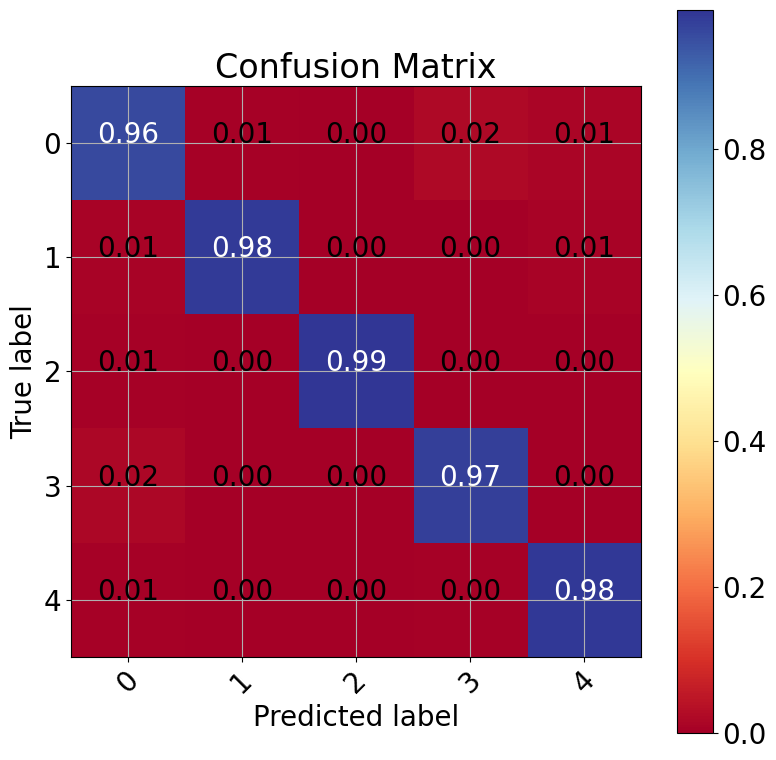

In [220]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, rf_predictions)
np.set_printoptions(precision=2)

print(classification_report(y_test, rf_predictions))

# Plot non-normalized confusion matrix
plt.figure(figsize=(8, 8))
plot_confusion_matrix(cnf_matrix, classes=['0','1', '2', '3', '4'],
                      title='Confusion Matrix')
plt.show()

In [229]:
#split data into testing, training, and validation sets

X_train, X_test, y_train, y_test = train_test_split(X_df_resam,category,test_size=0.3,stratify = category)
X_train, X_val, y_train, y_val = train_test_split(X_df_resam,category,test_size=0.3,stratify = category)

In [231]:
y_train=to_categorical(y_train)
y_test=to_categorical(y_test)
y_val=to_categorical(y_val)

In [232]:
print( "X_train Shape: ",X_train.shape, "X_test Shape: ",X_test.shape, "y_train Shape: ",y_train.shape, "y_test Shape: ",y_test.shape)

X_train Shape:  (21000, 360) X_test Shape:  (9000, 360) y_train Shape:  (21000, 5) y_test Shape:  (9000, 5)


In [320]:
mlp_model = Sequential()
mlp_model.add(Dense(50, activation='relu', input_shape=(X_train.shape[1],)))
mlp_model.add(Dense(50, activation='relu'))
mlp_model.add(Dense(50, activation='relu'))
ann_model.add(Dense(50, activation='relu'))
mlp_model.add(Dense(5, activation='softmax'))

mlp_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
mlp_model.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_93 (Dense)            (None, 50)                18050     
                                                                 
 dense_94 (Dense)            (None, 50)                2550      
                                                                 
 dense_95 (Dense)            (None, 50)                2550      
                                                                 
 dense_97 (Dense)            (None, 5)                 255       
                                                                 
Total params: 23,405
Trainable params: 23,405
Non-trainable params: 0
_________________________________________________________________


In [321]:
ann_model_history = ann_model.fit(X_train, y_train ,validation_data=(X_test, y_test), epochs=20)

Epoch 1/20
657/657 [==============================] - 1s 2ms/step - loss: 0.2083 - accuracy: 0.9229 - val_loss: 0.1707 - val_accuracy: 0.9318
Epoch 2/20
657/657 [==============================] - 1s 2ms/step - loss: 0.1798 - accuracy: 0.9349 - val_loss: 0.1401 - val_accuracy: 0.9497
Epoch 3/20
657/657 [==============================] - 1s 2ms/step - loss: 0.2005 - accuracy: 0.9255 - val_loss: 0.1350 - val_accuracy: 0.9508
Epoch 4/20
657/657 [==============================] - 1s 2ms/step - loss: 0.1792 - accuracy: 0.9328 - val_loss: 0.1471 - val_accuracy: 0.9484
Epoch 5/20
657/657 [==============================] - 1s 2ms/step - loss: 0.2010 - accuracy: 0.9242 - val_loss: 0.1376 - val_accuracy: 0.9554
Epoch 6/20
657/657 [==============================] - 1s 2ms/step - loss: 0.1924 - accuracy: 0.9283 - val_loss: 0.1296 - val_accuracy: 0.9520
Epoch 7/20
657/657 [==============================] - 1s 2ms/step - loss: 0.1726 - accuracy: 0.9360 - val_loss: 0.1335 - val_accuracy: 0.9521
Epoch 

Accuracy: 93.31%


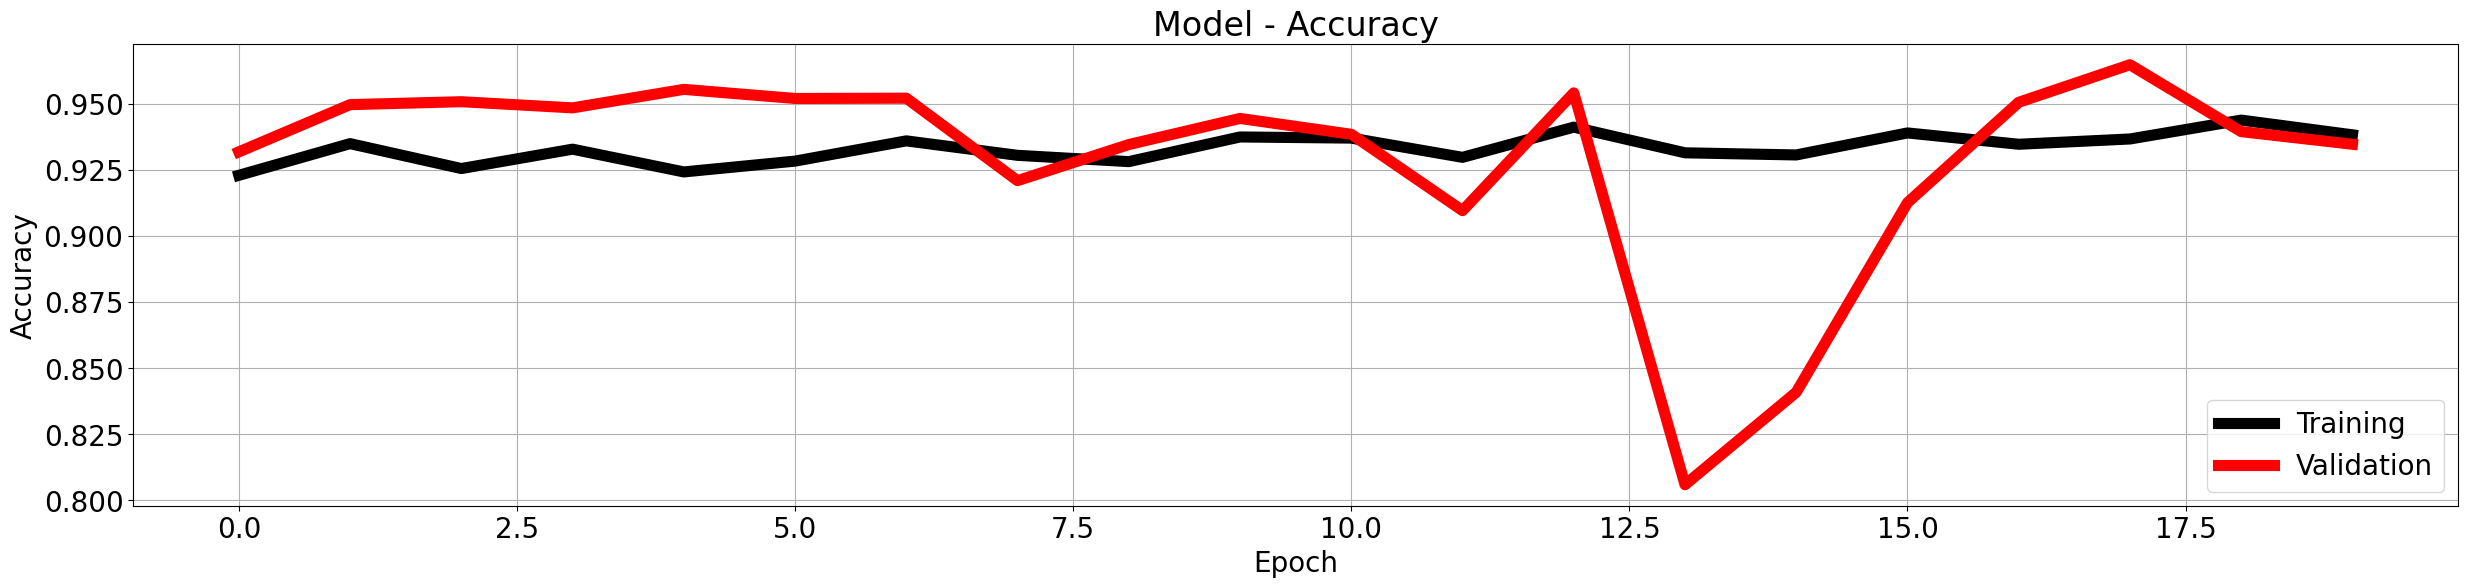

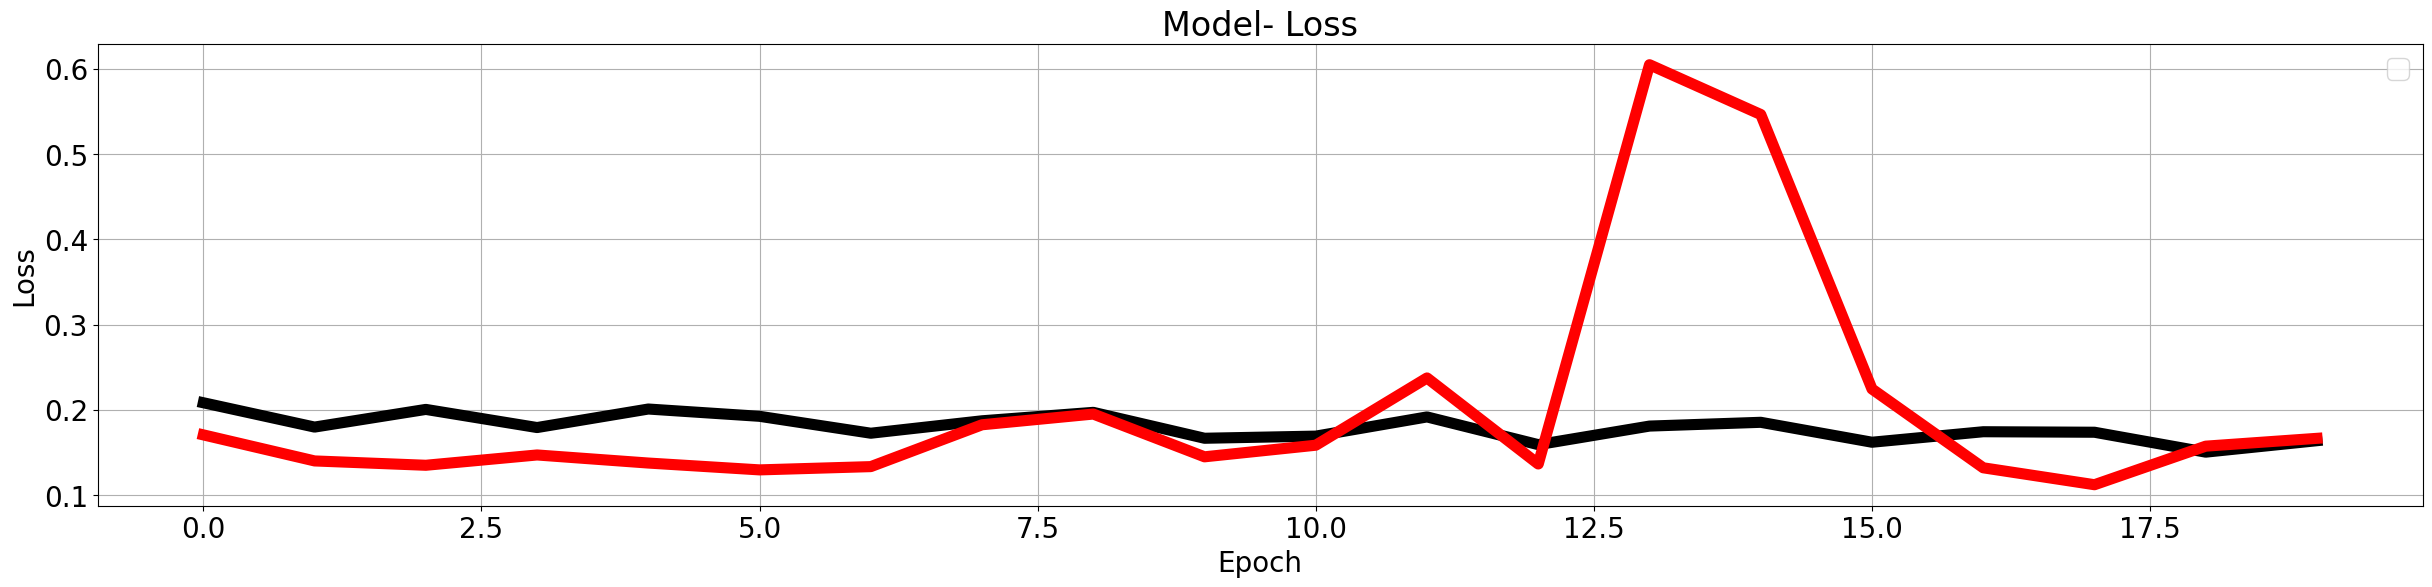

282/282 [==============================] - 0s 718us/step


In [322]:
evaluate_model(ann_model_history,X_val,y_val,ann_model)
y_pred=ann_model.predict(X_val)

              precision    recall  f1-score   support

           0       0.93      0.79      0.85      1800
           1       0.99      0.97      0.98      1800
           2       0.97      0.98      0.98      1800
           3       0.83      0.96      0.89      1800
           4       0.97      0.96      0.97      1800

    accuracy                           0.93      9000
   macro avg       0.94      0.93      0.93      9000
weighted avg       0.94      0.93      0.93      9000



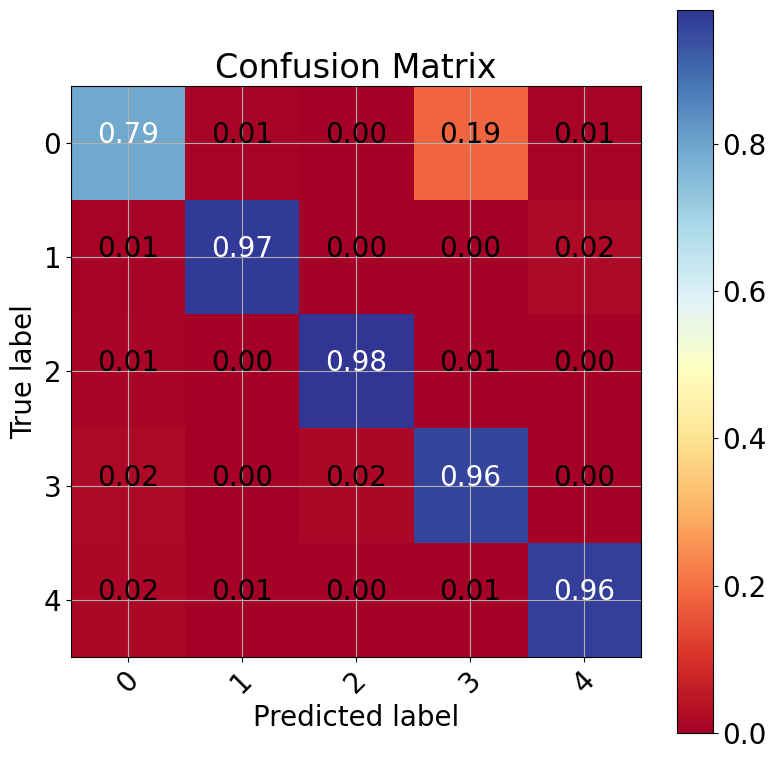

In [323]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_val.argmax(axis=1), y_pred.argmax(axis=1))
np.set_printoptions(precision=2)

print(classification_report(y_val.argmax(axis=1), y_pred.argmax(axis=1)))
# 
# Plot non-normalized confusion matrix
plt.figure(figsize=(8, 8))
plot_confusion_matrix(cnf_matrix, classes=['0','1', '2', '3', '4'],
                      title='Confusion Matrix')
plt.show()

# Deep Learning Model - Convolutional Neural Network

In [10]:
#split data into testing, training, and validation sets
X_train, X_test, y_train, y_test = train_test_split(X_df_resam,category,test_size=0.3,stratify = category)
na, X_val, na, y_val = train_test_split(X_df_resam,category,test_size=0.3,stratify = category)

In [11]:
#check that testing and validation are different
if X_test.equals(X_val)==True:
    print("The testing and validation sets are identical, perform splitting again")
else: 
    print("The testing and validation sets are not identical")

The testing and validation sets are not identical


In [12]:
y_train=to_categorical(y_train)
y_test=to_categorical(y_test)
y_val = to_categorical(y_val)

In [14]:

cnn_model = Sequential()

# Filters = Units in Dense Total number of Neurons
cnn_model.add(Convolution1D(filters = 64, kernel_size = 6, activation='relu', padding = 'same', input_shape = (X_train.shape[1], 1))) 
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPool1D(pool_size=(3), strides = (2), padding = 'same'))

cnn_model.add(Convolution1D(filters = 64, kernel_size = 6, activation='relu', padding = 'same'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPool1D(pool_size=(3), strides = (2), padding = 'same'))

cnn_model.add(Convolution1D( filters = 64, kernel_size = 6, activation='relu', padding = 'same'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPool1D(pool_size=(3), strides = (2), padding = 'same'))

# Flatten 
cnn_model.add(Flatten())

cnn_model.add(Dense(units = 64, activation='relu'))
cnn_model.add(Dense(units = 64, activation='relu'))
cnn_model.add(Dense(units = 5, activation='softmax'))

# loss = 'categorical_crossentropy'
cnn_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 360, 64)           448       
                                                                 
 batch_normalization (BatchN  (None, 360, 64)          256       
 ormalization)                                                   
                                                                 
 max_pooling1d (MaxPooling1D  (None, 180, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 180, 64)           24640     
                                                                 
 batch_normalization_1 (Batc  (None, 180, 64)          256       
 hNormalization)                                                 
                                                      

In [15]:
history = cnn_model.fit(X_train, y_train, epochs = 25, batch_size = 32, validation_data=(X_test, y_test))

Epoch 1/25
657/657 [==============================] - 13s 18ms/step - loss: 0.2306 - accuracy: 0.9220 - val_loss: 2.9400 - val_accuracy: 0.4506
Epoch 2/25
657/657 [==============================] - 11s 17ms/step - loss: 0.0764 - accuracy: 0.9751 - val_loss: 0.1160 - val_accuracy: 0.9647
Epoch 3/25
657/657 [==============================] - 11s 17ms/step - loss: 0.0585 - accuracy: 0.9811 - val_loss: 5.7390 - val_accuracy: 0.2794
Epoch 4/25
657/657 [==============================] - 12s 18ms/step - loss: 0.0469 - accuracy: 0.9857 - val_loss: 0.7269 - val_accuracy: 0.7350
Epoch 5/25
657/657 [==============================] - 12s 18ms/step - loss: 0.0318 - accuracy: 0.9890 - val_loss: 2.6136 - val_accuracy: 0.6012
Epoch 6/25
657/657 [==============================] - 11s 17ms/step - loss: 0.0260 - accuracy: 0.9916 - val_loss: 0.8266 - val_accuracy: 0.7642
Epoch 7/25
657/657 [==============================] - 11s 17ms/step - loss: 0.0300 - accuracy: 0.9908 - val_loss: 7.7765 - val_accuracy:

In [16]:
print("Model evaluated with test data: ",cnn_model.evaluate(X_test, y_test))
print("Model evaluated with validation data: ",cnn_model.evaluate(X_val, y_val))

282/282 [==============================] - 2s 6ms/step - loss: 0.0802 - accuracy: 0.9824
Model evaluated with test data:  [0.08015761524438858, 0.9824444651603699]
282/282 [==============================] - 2s 6ms/step - loss: 0.0443 - accuracy: 0.9882
Model evaluated with validation data:  [0.04432832822203636, 0.9882222414016724]


Accuracy: 98.82%


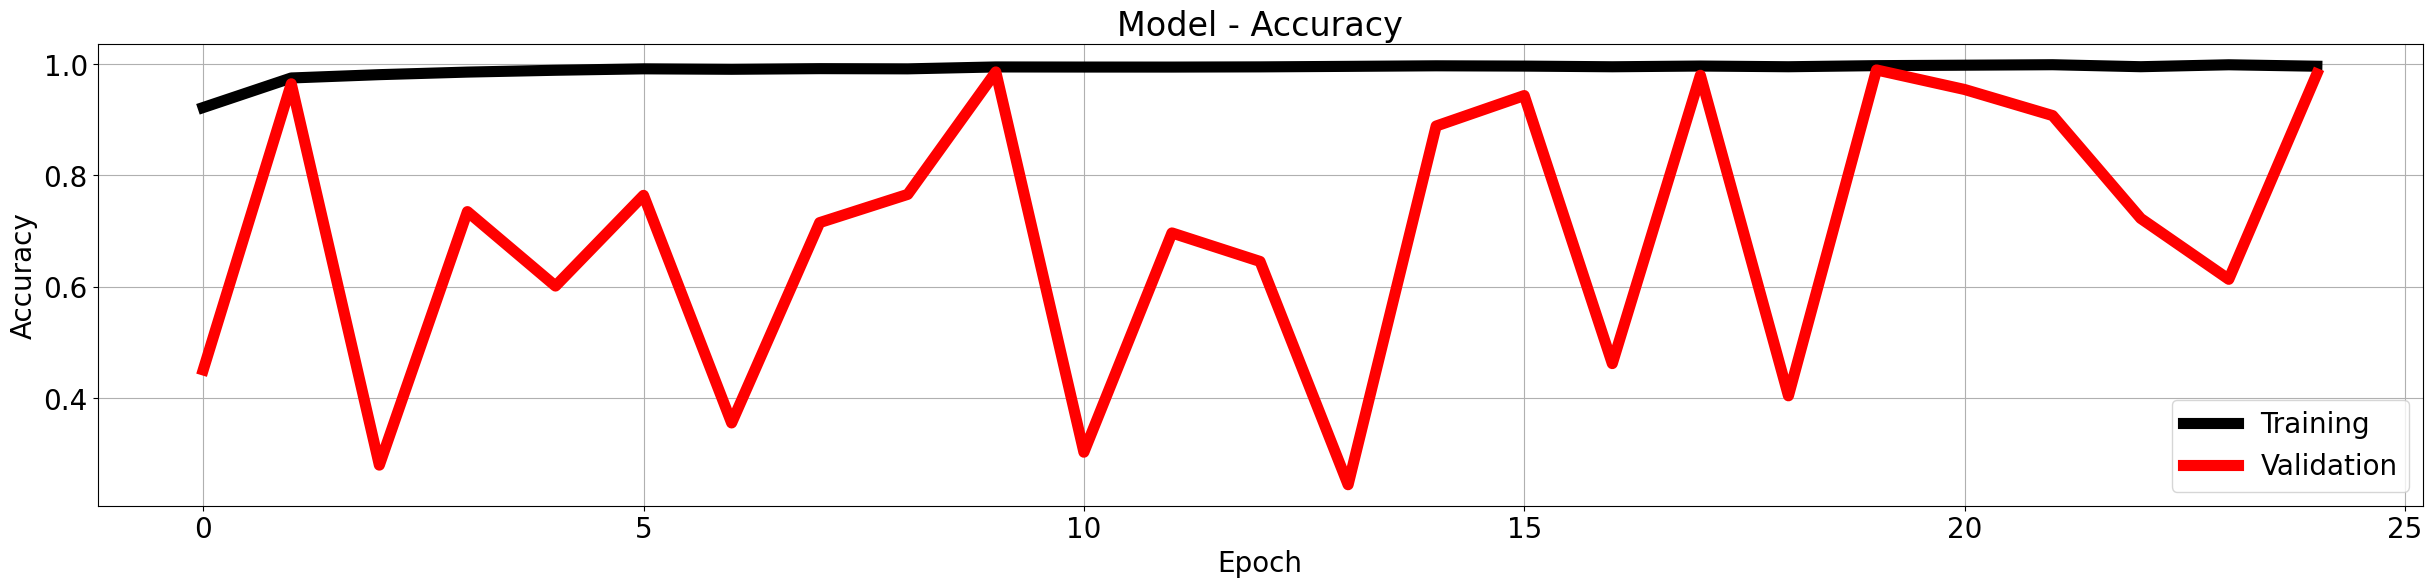

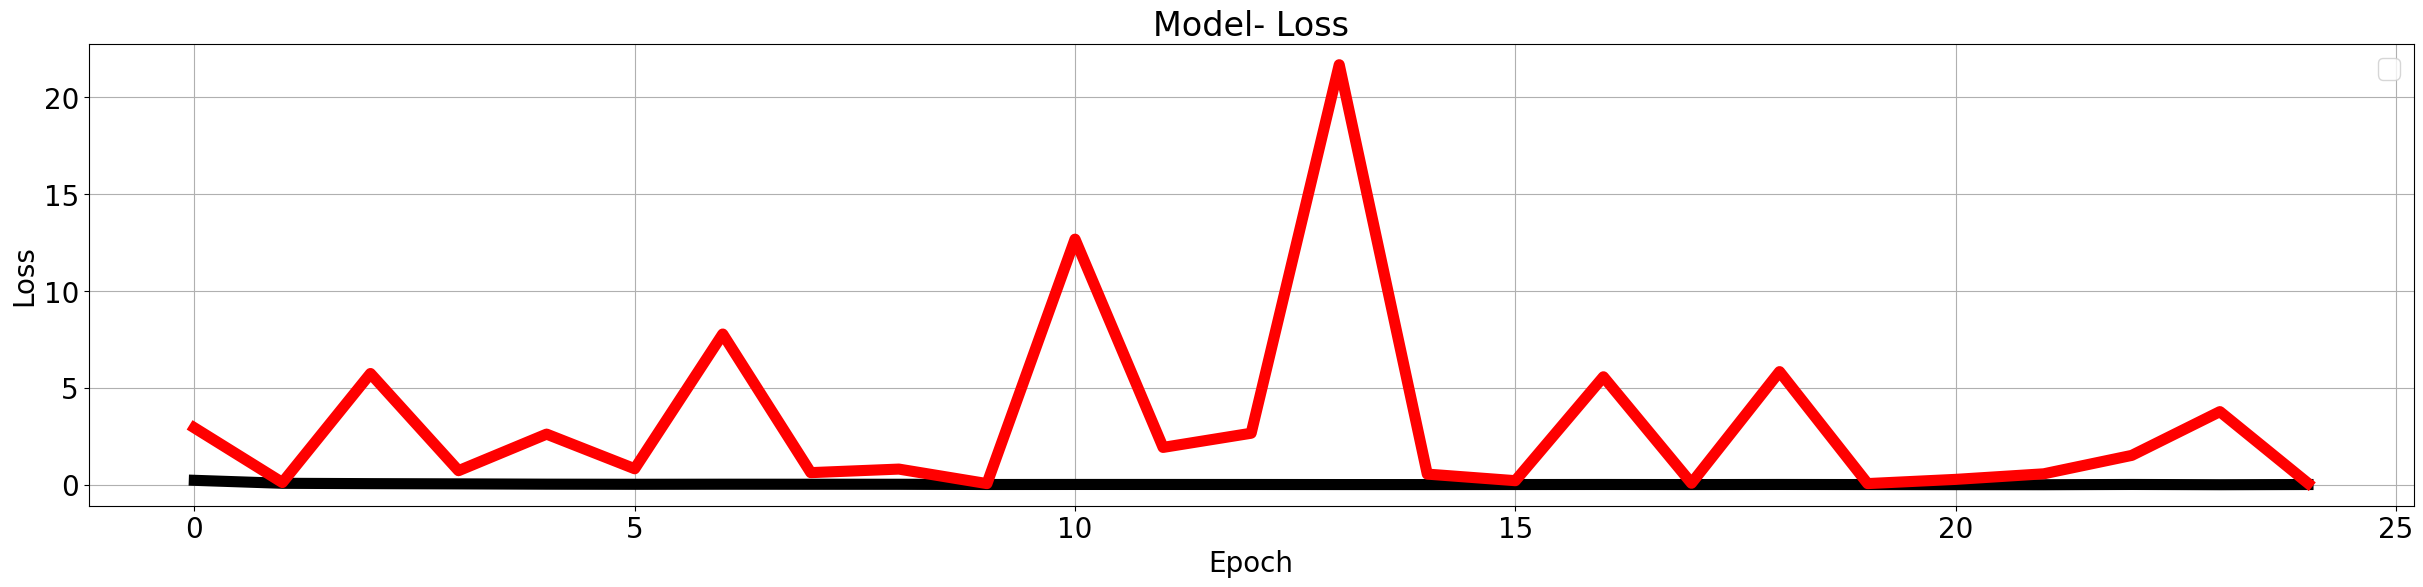

282/282 [==============================] - 2s 6ms/step


In [19]:
evaluate_model(history,X_val,y_val,cnn_model)
y_pred=cnn_model.predict(X_val)

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1800
           1       1.00      1.00      1.00      1800
           2       1.00      0.99      0.99      1800
           3       0.99      0.96      0.98      1800
           4       0.98      1.00      0.99      1800

    accuracy                           0.99      9000
   macro avg       0.99      0.99      0.99      9000
weighted avg       0.99      0.99      0.99      9000



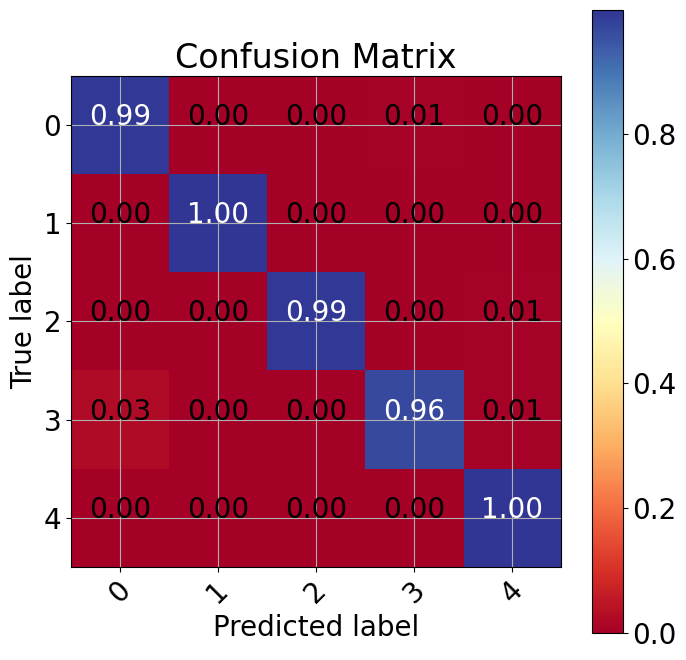

In [25]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_val.argmax(axis=1), y_pred.argmax(axis=1))
np.set_printoptions(precision=2)

print(classification_report(y_val.argmax(axis=1), y_pred.argmax(axis=1)))

# Plot non-normalized confusion matrix
plt.figure(figsize=(7, 7))
plot_confusion_matrix(cnf_matrix, classes=['0','1', '2', '3', '4'],
                      title='Confusion Matrix')
plt.show()

In [21]:
f1_score(y_val.argmax(axis=1), y_pred.argmax(axis=1), average='macro')

0.9882149458159274

In [22]:
precision_score(y_val.argmax(axis=1), y_pred.argmax(axis=1), average='macro')

0.9883911507520576

In [23]:
recall_score(y_val.argmax(axis=1), y_pred.argmax(axis=1), average='macro')

0.9882222222222221

In [24]:
accuracy_score(y_val.argmax(axis=1), y_pred.argmax(axis=1))

0.9882222222222222